In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
SEED = 42

In [5]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import requests
import xml.etree.ElementTree as ET
import json
import csv

# Drugs Collection

### **RXCONSO**
We start by reading RXCONSO as a RxNorm RRF file into a pandas DataFrame, selecting specific columns and removing duplicate rows based on the first column. The resulting DataFrame has unique values from the specified columns, thus, we are gettin a clean DataFrame.

In [ ]:
file_path = '/content/drive/MyDrive/DTU/SG/Project/RXNCONSO.RRF'

# Read the RxNorm RRF file into a pandas DataFrame
data = pd.read_csv(file_path, sep='|', usecols=[0, 14], header=None)

# Remove duplicated values in column 0 and take only the first occurrence
data = data.drop_duplicates(subset=[data.columns[0]])

# Print the resulting DataFrame
print(data)


             0                                                  14
0            38                                           Parlodel
1            44                                              mesna
4            61                                       beta-alanine
6            73                                   docosahexaenoate
7            74                                4-aminobenzoic acid
...         ...                                                ...
244483  2668200  adapalene 0.0015 MG/MG / benzoyl peroxide 0.03...
244484  2668201                            Cabtreo Topical Product
244485  2668202  adapalene / benzoyl peroxide / clindamycin Top...
244486  2668203  adapalene / benzoyl peroxide / clindamycin pho...
244487  2668204  CLINDAMYCIN PHOSPHATE 12 mg in 1 g / BENZOYL P...

[80170 rows x 2 columns]


### **RXNSTY**

We continue by following the same exact procedure as before with RXNSTY, selecting fewer columns and cleaning it the same way.

In [ ]:
file_path = '/content/drive/MyDrive/DTU/SG/Project/RXNSTY.RRF'

# Read the RxNorm RRF file into a pandas DataFrame
data_types = pd.read_csv(file_path, sep='|', usecols=[0, 3], header=None)

# Remove duplicated values in column 0 and take only the first occurrence
data_types = data_types.drop_duplicates(subset=[data_types.columns[0]])

# Print the resulting DataFrame
print(data_types)


              0                                3
0             3                           Enzyme
2            19                          Hormone
4            21                          Hormone
6            22          Pharmacologic Substance
8            33  Amino Acid, Peptide, or Protein
...         ...                              ...
459980  2668204                    Clinical Drug
459981  2668205                    Clinical Drug
459982  2668206                    Clinical Drug
459983  2668207                    Clinical Drug
459984  2668208                    Clinical Drug

[388330 rows x 2 columns]


## *Merge data*
The code now merges both our data and data types DataFrame into a merged_data one.

In [ ]:
# Merge data and data_types on the first column
merged_data = pd.merge(data, data_types, how='inner', left_on=data.columns[0], right_on=data_types.columns[0])

# Print the resulting DataFrame
print(merged_data)

            0                                                  14  \
0           38                                           Parlodel   
1           44                                              mesna   
2           61                                       beta-alanine   
3           73                                   docosahexaenoate   
4           74                                4-aminobenzoic acid   
...        ...                                                ...   
80165  2668200  adapalene 0.0015 MG/MG / benzoyl peroxide 0.03...   
80166  2668201                            Cabtreo Topical Product   
80167  2668202  adapalene / benzoyl peroxide / clindamycin Top...   
80168  2668203  adapalene / benzoyl peroxide / clindamycin pho...   
80169  2668204  CLINDAMYCIN PHOSPHATE 12 mg in 1 g / BENZOYL P...   

                                  3   
0                   Organic Chemical  
1                   Organic Chemical  
2      Biologically Active Substance  
3      Biologic

The extraction of unique values from the third column of `merged_data` is made and then the count of these unique classes is printed as the output. It can be seen that there are 31 unique classes.

In [ ]:
second_column_name = merged_data.columns[2]
unique_classes = merged_data[second_column_name].unique()
print(len(unique_classes))

31


What we aim to do now is to retrieve content from Wikipedia for a subset of drugs and save that relevant data into a CSV file. We have made it work like:

1.   Wikipedia API Query:
The get_wikipage function elaborates a query to the Wikipedia API. It takes a drug's name as input, replaces spaces with underscores, and retrieves plain text extracts from the Wikipedia page. Finally, the function will return the extracted content.
2. Subset of Drugs:
We follow by taking the first 5000 rows of the merged_data DataFrame and forms a list of drug tuples (rxcui, full_name, drug_class).
3.   Fetching Wikipedia Content:
Then we iterate over the list of drugs, trying to fetch Wikipedia content for each drug using the get_wikipage function. If we achieve to get not empty and successful content, it is added to the drugs_data list.
4.   CSV File Creation:
The script then writes the collected drug data to a CSV file named 'drugs_final.csv' with columns 'rxcui', 'name', 'class'. It handles potential encoding issues and writes the data using the csv module.
5.   Error Handling:
The code prints a count of drugs processed in increments of 100 and handles JSON decoding errors, printing an error message for problematic cases. The error messages suggest that there were issues decoding JSON for specific drugs, possibly due to unexpected content from the Wikipedia API.

In [ ]:
import requests
import xml.etree.ElementTree as ET
import json
import pandas as pd
import csv

def get_wikipage(wiki_name):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = f"titles={wiki_name.replace(' ', '_')}"
    content = "prop=extracts&explaintext"  # Get plain text extracts
    dataformat = "format=json"

    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    response = requests.get(query)
    wikitext = response.content.decode('utf-8')

    try:
        d = json.loads(wikitext)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON for {wiki_name}: {e}")
        return None

    page = d['query']['pages']
    page_id = list(page.keys())[0]

    # If the page does not exist
    if page_id == "-1":
        return None

    page_content = page[page_id].get('extract', None)
    return page_content

# Find the content for 5000 drugs
subset_merged_data = merged_data.head(5000)


drugs = [(rxcui, full_name, drug_class) for index, (rxcui, full_name, drug_class) in subset_merged_data.iterrows()]

# Initialize lists to accumulate data
drugs_data = []
interactions_data = []

# Track the number of drugs with Wikipedia content
count_wikipedia = 0

# Fetch Wikipedia content for the first 1000 drugs
for source_rxcui, name_source, drug_class in drugs:

    if count_wikipedia % 100 == 0:
      print(count_wikipedia)

    wikipedia_content = get_wikipage(name_source)
    if wikipedia_content is not None and wikipedia_content.strip() != "":
        drugs_data.append({'rxcui': source_rxcui, 'name': name_source, 'class': drug_class, 'content': wikipedia_content})
    count_wikipedia += 1

drugs_csv_path = '/content/drive/MyDrive/DTU/SG/Project/drugs_final.csv'


# Use list comprehensions for writing to CSV
with open(drugs_csv_path, 'w', newline='', encoding='utf-8') as drugs_file:
    writer = csv.writer(drugs_file, quoting=csv.QUOTE_ALL, escapechar='\\')
    writer.writerow(['rxcui', 'name', 'class'])
    writer.writerows([drug['rxcui'], drug['name'], drug['class']] for drug in drugs_data)


0


KeyboardInterrupt: ignored

This chunk of code aims to create a dataset of drugs with associated Wikipedia content. The error messages indicate that there have been problems in obtaining Wikipedia content for specific drugs.

We create a list of 'rxcui' values from the first column of the 'merged_data' DataFrame.

In [ ]:
rxcuis = merged_data.iloc[:, 0].values
rxcuis = rxcuis.tolist()

## *DDI Collection*

### *DrugBank DDIs*

The code now extracts drug interactions from the RxNav API for a specified drug subset and appends the results to 'interactions_big_DrugBank.csv'.

In [ ]:
start_index = 0
end_index = 5000

target_rxcuis_set = rxcuis[start_index:end_index]

count = 0
interactions_data = []


for drug in target_rxcuis_set:
    url = f"https://rxnav.nlm.nih.gov/REST/interaction/interaction?rxcui={drug}&sources=DrugBank"
    response = requests.get(url)

    if response.status_code == 200:
        root = ET.fromstring(response.text)

        for interaction in root.findall('.//interactionPair'):
            description = interaction.find('.//description').text
            interaction_concepts = interaction.findall('.//interactionConcept')

            if len(interaction_concepts) >= 2:
                dest_rxcui = int(interaction_concepts[1].find('.//rxcui').text)

                interactions_data.append({
                    'rxcui_source': drug,
                    'rxcui_target': dest_rxcui,
                    'description': description
                })

    count += 1
    if count % 100 == 0:
      print(count)

interactions_csv_path = '/content/drive/MyDrive/DTU/SG/Project/graphextraction/interactions_big_DrugBank.csv'

with open(interactions_csv_path, 'a', newline='', encoding='utf-8') as interactions_file:
    writer = csv.writer(interactions_file, quoting=csv.QUOTE_ALL, escapechar='\\')
    if start_index == 0:
        writer.writerow(['rxcui_source', 'rxcui_target', 'description'])
    writer.writerows([interaction['rxcui_source'], interaction['rxcui_target'], interaction['description']] for interaction in interactions_data)

print(f"Interactions CSV file saved at: {interactions_csv_path}")

### *ONCHigh DDIs*

Same procedure is being made here, but now we are using the RxNav API and saving the results in 'interactions_big_ONCHigh.csv'.

In [ ]:
start_index = 0
end_index = 5000

target_rxcuis_set = rxcuis[start_index:end_index]

count = 0
interactions_data = []


for drug in target_rxcuis_set:
    url = f"https://rxnav.nlm.nih.gov/REST/interaction/interaction?rxcui={drug}&sources=ONCHigh"
    response = requests.get(url)

    if response.status_code == 200:
        root = ET.fromstring(response.text)

        for interaction in root.findall('.//interactionPair'):
            description = interaction.find('.//description').text
            interaction_concepts = interaction.findall('.//interactionConcept')

            if len(interaction_concepts) >= 2:
                dest_rxcui = int(interaction_concepts[1].find('.//rxcui').text)


                interactions_data.append({
                    'rxcui_source': drug,
                    'rxcui_target': dest_rxcui,
                    'description': description
                })

    count += 1
    if count % 100 == 0:
      print(count)

interactions_csv_path = '/content/drive/MyDrive/DTU/graphextraction/interactions_big_ONCHigh.csv'

with open(interactions_csv_path, 'a', newline='', encoding='utf-8') as interactions_file:
    writer = csv.writer(interactions_file, quoting=csv.QUOTE_ALL, escapechar='\\')
    if start_index == 0:
        writer.writerow(['rxcui_source', 'rxcui_target', 'description'])
    writer.writerows([interaction['rxcui_source'], interaction['rxcui_target'], interaction['description']] for interaction in interactions_data)

print(f"Interactions CSV file saved at: {interactions_csv_path}")

# Part 0: Building the network

### *Loading and Cleaning Data*
The code begins with the importation of libraries such as Pandas (data manipulation), NetworkX (graph creation) and Matplotlib (visualization). There is also a definition of a function called "preprocess_dataframe" that eliminates the duplicates and self-loops from the DataFrame.



In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def preprocess_dataframe(df):
    # Remove duplicates and self-loops
    df = df.drop_duplicates(subset=['rxcui_source', 'rxcui_target'])
    df = df[df['rxcui_source'] != df['rxcui_target']]
    df = df.reset_index(drop=True)
    return df

### *Loading Interaction and Drug Data*
Then we continue by loading the interaction data from CSV files ('interactions_big_ONCHigh.csv' and 'interactions_big_DrugBank.csv') and drug data from 'drugs_final.csv'. Both interaction files are preprocessed using the function defined before.


In [7]:
# Load the data from CSV files
high_priority_df = preprocess_dataframe(pd.read_csv('/content/drive/MyDrive/DTU/SG/Project/interactions_big_ONCHigh.csv'))
all_interactions_df = preprocess_dataframe(pd.read_csv('/content/drive/MyDrive/DTU/SG/Project/interactions_big_DrugBank.csv'))
drugs_df = pd.read_csv('/content/drive/MyDrive/DTU/SG/Project/drugs_final.csv')

### *Building the Graph*
Using NetworkX, we create an undirected graph (G). The nodes are added to the graph and the attributes that are being used are sourced from the drugs DataFrame. After that, edges are added and also interaction data and associated attributes.

In [8]:
# Create an undirected graph using NetworkX
G = nx.Graph()

# Add nodes with attributes from drugs dataframe
for _, drug_row in drugs_df.iterrows():
    G.add_node(drug_row['rxcui'], name=drug_row['name'], drug_class=drug_row['class'], content=drug_row['content'])

# Add edges and attributes from interactions dataframe
for _, interaction_row in all_interactions_df.iterrows():
    source = int(interaction_row['rxcui_source'])
    target = int(interaction_row['rxcui_target'])
    description = interaction_row['description']

    # Check if nodes exist before adding the edge
    if G.has_node(source) and G.has_node(target):
        G.add_edge(source, target, description=description, priority='Low Priority')

### *Adding Priority Labels*
The code then looks into the 'high_priority_df' and incorporates a new label attribute for high-priority interactions.

In [9]:
for _, interaction_row in high_priority_df.iterrows():
    source = int(interaction_row['rxcui_source'])
    target = int(interaction_row['rxcui_target'])
    description = interaction_row['description']

    # Check if the edge exists before adding the label attribute
    if G.has_edge(source, target):
        G[source][target]['priority'] = 'High Priority'
        G[source][target]['description'] = description

After this chunks of code, the graph representing drug interactions completed with priority labels for high-priority interactions is finally created.

### *Extracting High-Priority Subgraph*
The code continues by extracting a subgraph from the principal graph (G) that is only containing the edges marked as 'High Priority'. For creating the subgraph (subgraph_high_priority) a list to identify edges with the specified priority label is used.

In [10]:
# Extract subgraph with high-priority edges
high_priority_edges = [(source, target) for source, target, data in G.edges(data=True) if 'priority' in data and data['priority'] == 'High Priority']
subgraph_high_priority = G.edge_subgraph(high_priority_edges)

### *Node Degrees and Size Scaling*
The following chunk computes the drgrees of nodes within the high-priority subgraph and it makes the information to be stored in a dictionary called node_degrees. After that, an scalation is being made to the node sizes based on their degrees to ensure a visual representation that focuses on highlighting nodes with higher degrees.

In [11]:
# Get node degrees
node_degrees = dict(subgraph_high_priority.degree())

# Scale node sizes based on degrees
node_sizes = [10 * node_degrees[node] for node in subgraph_high_priority.nodes()]

### *Drawing and Displaying the Subgraph*

We will now draw the subgraph. The configuration that we have chosen allows us to display node labels with bold fonts for emphasis. It can also be seen the scalation of node sizes accrding to their degrees.

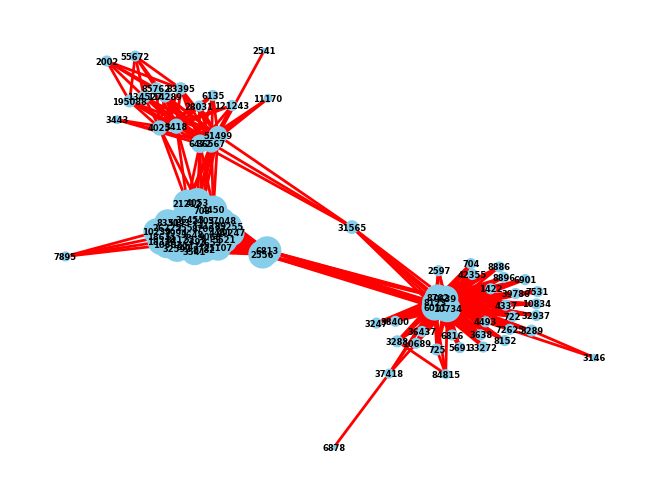

In [49]:
# Draw the subgraph
pos = nx.spring_layout(subgraph_high_priority)  # You can choose a different layout if needed
nx.draw(subgraph_high_priority, pos, with_labels=True, font_weight='bold', node_size=node_sizes, node_color='skyblue', font_size=6, edge_color='red', width=2)

# Show the plot
plt.show()

Suming up this part of the code, it basically generates a clear visualization of the high-priority interactions subgraph to facilitate the most critical relationships in the dataset.

# Part 1: Network visualization and basic stats

## *Graph Summary*
This code provides a simple summary of the graph:



In [13]:
# Print the graph nodes and edges
print("Nodes:", len(G.nodes()))
print("Edges:", len(G.edges()))

Nodes: 1168
Edges: 139223


Here, we print the number of nodes (elements) and edges (connections) in the graph represented by the variable G. This is an easy and quick way to check the basic size and structure of the graph.

We continue by isolating the largest connected component to simplify the analysis and to better understand the main structure and relationships within the graph. The following chunks of code will provide an exploration of the mentioned graph.

In [14]:
# Find connected components
connected_components = list(nx.connected_components(G))

# Find the largest connected component
lCC = max(connected_components, key=len)

# Create a subgraph of the largest connected component
larg_comp = G.subgraph(lCC)

## *Largest Connected Components Graph Summary*


*A) Number of nodes*

In [15]:
# Total nodes in the Graph (LWCC)
total_nodes = len(larg_comp.nodes())
print("Total number of nodes in the Graph (LWCC): {}".format(total_nodes))

Total number of nodes in the Graph (LWCC): 914


*B) Number of edges*

In [16]:
# Total edges in the Graph (LWCC)
total_edges = len(larg_comp.edges())
print("Total number of edges in the Graph (LWCC): {}".format(total_edges))

Total number of edges in the Graph (LWCC): 139223


*C) Number of high priority interactions*

In [17]:
high_priority_count = sum(1 for source, target, data in larg_comp.edges(data=True) if 'priority' in data and data['priority'] == 'High Priority')

# Print the count
print(f"Number of high-priority interactions in the largest connected component: {high_priority_count}")

Number of high-priority interactions in the largest connected component: 802


*D) Top nodes with highest in degree and out degree*

In [18]:
# Degree dictionary for undirected graph
degree_dict = dict(larg_comp.degree(larg_comp.nodes()))

# Top k nodes with highest degree
k = 5
sorted_degree_dict = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)

print("Top {} nodes with the highest degree:".format(k))
for i in range(k):
    node_id = sorted_degree_dict[i][0]
    degree = sorted_degree_dict[i][1]

    # Access the drug name attribute
    drug_name = larg_comp.nodes[node_id].get('name', 'Unknown Drug')

    # Count the number of high-priority interactions for the top nodes
    high_priority_degree = sum(1 for neighbor in larg_comp.neighbors(node_id)
                               if 'priority' in larg_comp[node_id][neighbor] and
                               larg_comp[node_id][neighbor]['priority'] == 'High Priority')

    print(f"Drug {drug_name} with degree {degree} and {high_priority_degree} high-priority interactions")


Top 5 nodes with the highest degree:
Drug chlorpromazine with degree 709 and 33 high-priority interactions
Drug clozapine with degree 708 and 0 high-priority interactions
Drug quinidine with degree 676 and 33 high-priority interactions
Drug amitriptyline with degree 671 and 5 high-priority interactions
Drug imipramine with degree 669 and 5 high-priority interactions


Some of the observations that can be drawn from the output:


*   The degree indicates the number of connections each drug has in the graph.
*   Chlorpromazine and Clozapine have the highest degrees, while Clozapine has no high-priority interactions.
*   Quinidine, Amitriptyline, and Imipramine also have substantial degrees with varying high-priority interactions.

This analysis provides a quick overview of the most connected drugs in the network, highlighting their degrees and the number of high-priority interactions.






In [19]:
# Calculate the number of high-priority interactions for each node
high_priority_degree_dict = {}
for node_id in larg_comp.nodes:
    high_priority_degree = sum(1 for neighbor in larg_comp.neighbors(node_id)
                               if 'priority' in larg_comp[node_id][neighbor] and
                               larg_comp[node_id][neighbor]['priority'] == 'High Priority')
    high_priority_degree_dict[node_id] = high_priority_degree

# Top k nodes with the highest degree of high-priority interactions
k = 5
sorted_high_priority_degree_dict = sorted(high_priority_degree_dict.items(), key=lambda x: x[1], reverse=True)[:k]

print(f"\nTop {k} nodes with the highest degree of high-priority interactions:")
for node_id, high_priority_degree in sorted_high_priority_degree_dict:
    degree = degree_dict[node_id]
    drug_name = larg_comp.nodes[node_id].get('name', 'Unknown Drug')
    print(f"Drug {drug_name} with degree {degree} and {high_priority_degree} high-priority interactions")


Top 5 nodes with the highest degree of high-priority interactions:
Drug citalopram with degree 466 and 38 high-priority interactions
Drug erythromycin with degree 388 and 38 high-priority interactions
Drug methadone with degree 609 and 38 high-priority interactions
Drug clarithromycin with degree 379 and 38 high-priority interactions
Drug amiodarone with degree 572 and 36 high-priority interactions


The extended analysis continues with high-priority interactions for each node, providing insights into the drugs with the highest degrees of such interactions:


*   These drugs show both a high degree as well as a high number of high-priority interactions, indicating their importance in the network.
*   Notably, Citalopram, Erythromycin, and Methadone share the highest count of high-priority interactions.



*E) Plot in degree and out degree distributions*

The following plots show how nodes are connected between them and highlight important connections. They help us see how many connections each node has and which ones are particularly significant.

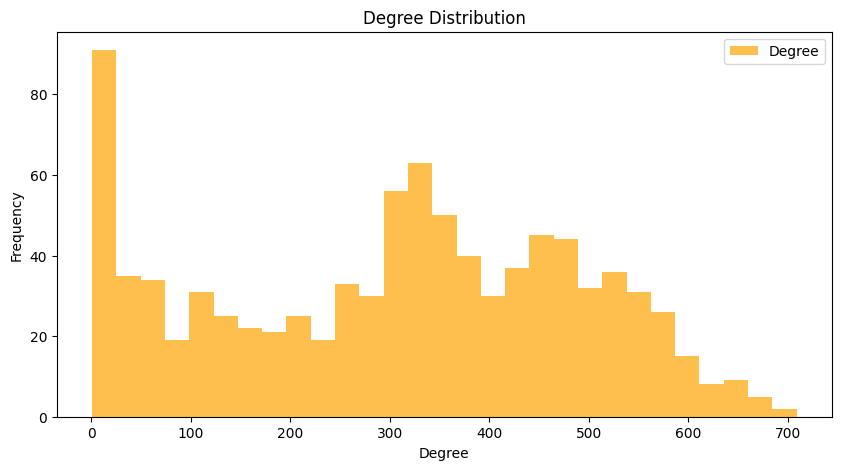

In [20]:
degree_list_all = list(degree_dict.values())

bins = np.linspace(min(degree_list_all), max(degree_list_all), 30)

degree_freq, degree_bin_edges = np.histogram(degree_list_all, bins=bins, density=False)
degree_bin_centers = 0.5 * (degree_bin_edges[1:] + degree_bin_edges[:-1])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

degree_color = 'orange'

ax.hist(degree_bin_centers, bins, weights=degree_freq, label="Degree", alpha=0.7, color=degree_color)

ax.set_xlabel("Degree")
ax.set_ylabel("Frequency")
ax.legend(loc='upper right')
ax.set_title("Degree Distribution")

plt.show()

It can be seen that the degree distribution plot is quite wide spreaded. This is suggesting a diverse range of degrees among nodes. Although the highest peak of the degrees is displayed in the value 0, there can be seen other peaks along the distribution.

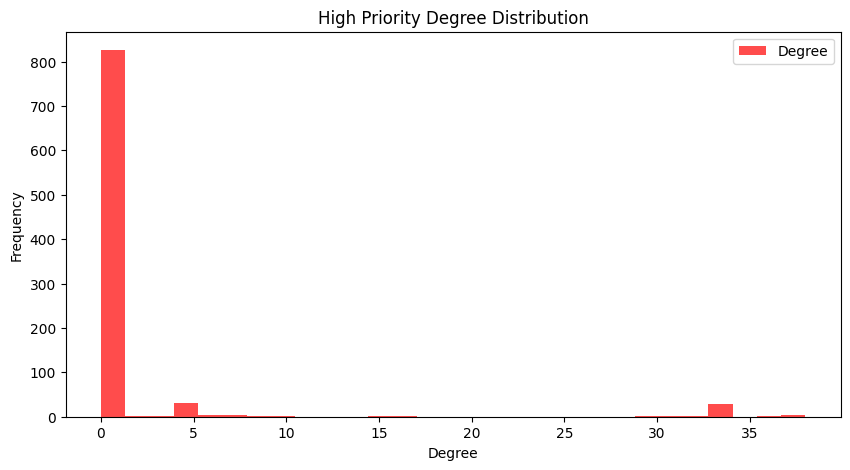

In [21]:
degree_list_sub = list(high_priority_degree_dict.values())

bins = np.linspace(min(degree_list_sub), max(degree_list_sub), 30)

degree_freq, degree_bin_edges = np.histogram(degree_list_sub, bins=bins, density=False)
degree_bin_centers = 0.5 * (degree_bin_edges[1:] + degree_bin_edges[:-1])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

degree_color = 'red'

ax.hist(degree_bin_centers, bins, weights=degree_freq, label="Degree", alpha=0.7, color=degree_color)

ax.set_xlabel("Degree")
ax.set_ylabel("Frequency")
ax.legend(loc='upper right')
ax.set_title("High Priority Degree Distribution")

plt.show()

In the high-priority degree distribution plot there is no shape at all. This histogram specifically focuses on nodes with high-priority interactions. The most noticable thing is that almost all of the degrees have a value of 0.

*F) Calculate the counts and unique degrees for the entire graph and subgraph.*

This code compares and visualizes the logarithmic degree distributions of an entire graph and a subgraph. The resulting scatter plot distinguishes the entire graph in orange and the subgraph in blue, facilitating a quick comparison of their structural characteristics.

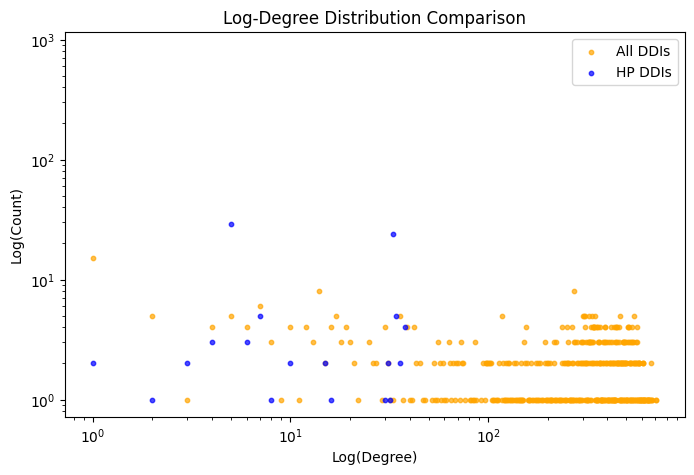

In [22]:
# Calculate the counts and unique degrees for the entire graph and subgraph
all_degrees, all_counts = np.unique(degree_list_all, return_counts=True)
sub_degrees, sub_counts = np.unique(degree_list_sub, return_counts=True)

# Plot degree distribution for the entire graph and subgraph together in log scale
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Scatter plot for the entire graph
ax.scatter(all_degrees, all_counts, color='orange', alpha=0.7, label='All DDIs', s=10)

# Scatter plot for the subgraph
ax.scatter(sub_degrees, sub_counts, color='blue', alpha=0.7, label='HP DDIs', s=10)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Log(Degree)")
ax.set_ylabel("Log(Count)")
ax.legend(loc='upper right')
ax.set_title("Log-Degree Distribution Comparison")

plt.show()

*G) Count all drugs whose in degree is zero and all those whose out degree is zero as well.*

We now want to identify the nodes with zero degrees and count them, thus isolated nodes without any connections will be indicated.

In [23]:
count_degree_zero = sum(1 for degree in degree_dict.values() if degree == 0)

print(f"Number of nodes with degree zero: {count_degree_zero} of 914")

Number of nodes with degree zero: 0 of 914


The output shows us that there are no nodes in the graph with zero degrees. This means that each node is connected to at least one other node. This leads to a fully connected network without isolated components.

We continue by following the same process to identify and count the nodes with a high-priority degree of zero in the graph.

In [24]:
count_degree_zero = sum(1 for degree in high_priority_degree_dict.values() if degree == 0)

print(f"Number of nodes with high priority degree zero: {count_degree_zero} of 914")

Number of nodes with high priority degree zero: 824 of 914


Now the new output indicated that 824 out of 914 nodes have a igh-priority degree of zero. This is a high number of nodes. The meaning behind this is that these nodes lack high-priority interactions and might be isolated from prioritized connections within the network.

## *Comparing Degree Distributions: Original vs. Random Graph*

This code segment generates a histogram to compare the degree distributions between the original graph (larg_comp) and a randomly generated graph (G_random).

The comparison helps us to  understand whether the original graph's degree distribution differs significantly from what would be expected in a random graph with similar characteristics.

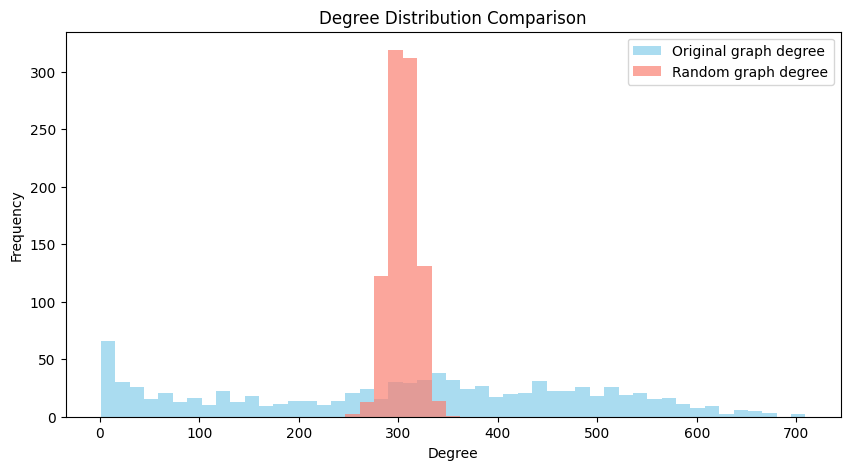

In [25]:
N = len(larg_comp.nodes)
p = len(larg_comp.edges) / (N * (N - 1) / 2)
G_random = nx.gnp_random_graph(N, p, seed=SEED)

degree_list_original = list(dict(larg_comp.degree).values())
degree_list_random = list(dict(G_random.degree).values())

bins = np.linspace(min(min(degree_list_original), min(degree_list_random)),
                   max(max(degree_list_original), max(degree_list_random)), 50)

degree_freq_original, degree_bin_edges_original = np.histogram(degree_list_original, bins=bins, density=False)
degree_freq_random, degree_bin_edges_random = np.histogram(degree_list_random, bins=bins, density=False)

degree_bin_centers_original = 0.5 * (degree_bin_edges_original[1:] + degree_bin_edges_original[:-1])
degree_bin_centers_random = 0.5 * (degree_bin_edges_random[1:] + degree_bin_edges_random[:-1])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

degree_color_original = 'skyblue'
degree_color_random = 'salmon'

ax.hist(degree_bin_centers_original, bins, weights=degree_freq_original, label="Original graph degree", alpha=0.7,
        color=degree_color_original)
ax.hist(degree_bin_centers_random, bins, weights=degree_freq_random, label="Random graph degree", alpha=0.7,
        color=degree_color_random)

ax.set_xlabel("Degree")
ax.set_ylabel("Frequency")
ax.legend(loc='upper right')
ax.set_title("Degree Distribution Comparison")

plt.show()

The differences in peak locations and frequency spread suggest that our original graph has unique characteristics that are not being replicated in a random graph.

Thus, this is telling to us that our original graph displays non-random connectivity patterns.

## *Centrality Analysis*

### *Node centrality*
Moving on, we will continue with the analysis of node centrality. However, first of all, we will clarify what node centrality is.

Node centrality measures the importance or influence of a node within a network. It quantifies a node's significance based on its position and interactions within the graph.

In [26]:
# Centrality measures
centrality_measures = [nx.degree_centrality, nx.closeness_centrality, nx.eigenvector_centrality]


k = 5

# Iterate over centrality measures
for centrality_measure in centrality_measures:
    centrality_scores = centrality_measure(larg_comp)
    top_nodes = sorted(centrality_scores, key=centrality_scores.get, reverse=True)[:k]

    # Print top k nodes and count of high-priority links
    print(f"\nTop {k} nodes based on {centrality_measure.__name__}:")
    for node in top_nodes:
        drug_name = larg_comp.nodes[node].get('name', 'Unknown Drug')
        high_priority_count = sum(1 for neighbor in larg_comp.neighbors(node) if 'priority' in larg_comp[node][neighbor] and larg_comp[node][neighbor]['priority'] == 'High Priority')
        print(f"{drug_name}: Centrality = {centrality_scores[node]}, High-Priority Links Count = {high_priority_count}")


Top 5 nodes based on degree_centrality:
chlorpromazine: Centrality = 0.7765607886089814, High-Priority Links Count = 33
clozapine: Centrality = 0.7754654983570646, High-Priority Links Count = 0
quinidine: Centrality = 0.7404162102957283, High-Priority Links Count = 33
amitriptyline: Centrality = 0.7349397590361446, High-Priority Links Count = 5
imipramine: Centrality = 0.732749178532311, High-Priority Links Count = 5

Top 5 nodes based on closeness_centrality:
chlorpromazine: Centrality = 0.8144513826940232, High-Priority Links Count = 33
clozapine: Centrality = 0.8137254901960784, High-Priority Links Count = 0
quinidine: Centrality = 0.7918473547267997, High-Priority Links Count = 33
amitriptyline: Centrality = 0.7877480586712683, High-Priority Links Count = 5
imipramine: Centrality = 0.7863910422049957, High-Priority Links Count = 5

Top 5 nodes based on eigenvector_centrality:
clozapine: Centrality = 0.060181512648966005, High-Priority Links Count = 0
chlorpromazine: Centrality = 0

According to the obtained output we can say that:


*   Chlorpromazine stands out as the most central node in terms of both degree and closeness centrality, having the highest number of connections and a central position in the network.
*   On the other hand, Clozapine, while highly connected, lacks high-priority links despite its centrality.
*   Interestingly, Clozapine gains importance in eigenvector centrality, indicating connections to well-connected nodes, but still lacks high-priority links.

In one hand, the centrality analysis is telling us that Chlorpromazine has a consistent pivotal role. On the other one, it is raising questions about Clozapine's significance despite its centrality in the network.

### *Edge centrality*

We will now perform edge centrality analysis. High-priority edge centrality tells us how important specific special connections are in a network. It helps measure the importance of these prioritized interactions, revealing crucial connections in the network.

In [27]:
centrality_measures = {
    'Edge Betweenness': nx.edge_betweenness_centrality(larg_comp)
}

k = 2

# Display the top k edges for each centrality measure
for centrality_name, centrality_values in centrality_measures.items():
    top_edges = sorted(centrality_values.items(), key=lambda x: x[1], reverse=True)[:k]
    print(f"Top {k} Edges based on {centrality_name} Centrality:")
    for edge, centrality in top_edges:
        print(f"Edge: {edge}, Centrality: {centrality}")
    print()

Top 2 Edges based on Edge Betweenness Centrality:
Edge: (10454, 10459), Centrality: 0.0021881838074398275
Edge: (4325, 6851), Centrality: 0.002188183807439826



The output identifies the top two edges that play a crucial role in facilitating efficient communication between different sections of the graph. The first edge, (10454, 10459), and the second edge, (4325, 6851), show the highest edge betweenness centrality. This means that they are important in maintaining connectivity and influencing information flow over the graph.







The following code is adding more information.

In [28]:
k = 10

# Display the top k edges for each centrality measure
for centrality_name, centrality_values in centrality_measures.items():
    top_edges = sorted(centrality_values.items(), key=lambda x: x[1], reverse=True)[:k]
    print(f"Top {k} Edges based on {centrality_name} Centrality:")
    for edge, centrality in top_edges:
        edge_info = larg_comp.get_edge_data(*edge)
        print(f"Centrality: {round(centrality,4)}, Edge: {edge_info}")
    print()

Top 10 Edges based on Edge Betweenness Centrality:
Centrality: 0.0022, Edge: {'description': 'The serum concentration of Linagliptin can be increased when it is combined with Thiamine.', 'priority': 'Low Priority'}
Centrality: 0.0022, Edge: {'description': 'The excretion of Methotrexate can be decreased when combined with Fenbendazole.', 'priority': 'Low Priority'}
Centrality: 0.0022, Edge: {'description': 'The therapeutic efficacy of Acetylcysteine can be decreased when used in combination with Trypsin.', 'priority': 'Low Priority'}
Centrality: 0.0022, Edge: {'description': 'The therapeutic efficacy of Acetylcysteine can be decreased when used in combination with Chymotrypsin.', 'priority': 'Low Priority'}
Centrality: 0.0022, Edge: {'description': 'The risk or severity of adverse effects can be increased when Glycine is combined with Digoxin.', 'priority': 'Low Priority'}
Centrality: 0.0022, Edge: {'description': 'The therapeutic efficacy of Lactulose can be decreased when used in com

The code evaluates the top 10 edges in the network using edge betweenness centrality, considering priority information. Each edge is presented with its centrality value, priority level, and interaction description. For instance, edge (10454, 10459) has a centrality of 0.0022, indicating a low-priority interaction affecting Linagliptin and Thiamine serum concentration. Another notable edge is (4325, 6851) with the same centrality, involving decreased Methotrexate excretion when combined with Fenbendazole.

## *Drug Classes Analysis*

Biologically Active Substance: 10 drugs (1.09%)
Pharmacologic Substance: 345 drugs (37.75%)
Indicator, Reagent, or Diagnostic Aid: 6 drugs (0.66%)
Organic Chemical: 392 drugs (42.89%)
Antibiotic: 48 drugs (5.25%)
Inorganic Chemical: 22 drugs (2.41%)
Amino Acid, Peptide, or Protein: 38 drugs (4.16%)
Nucleic Acid, Nucleoside, or Nucleotide: 13 drugs (1.42%)
Hormone: 19 drugs (2.08%)
Vitamin: 8 drugs (0.88%)
Enzyme: 3 drugs (0.33%)
Hazardous or Poisonous Substance: 4 drugs (0.44%)
Element, Ion, or Isotope: 4 drugs (0.44%)
Immunologic Factor: 1 drugs (0.11%)
Clinical Drug: 1 drugs (0.11%)


<ipython-input-29-ab6dc56490cc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45, ha='right')


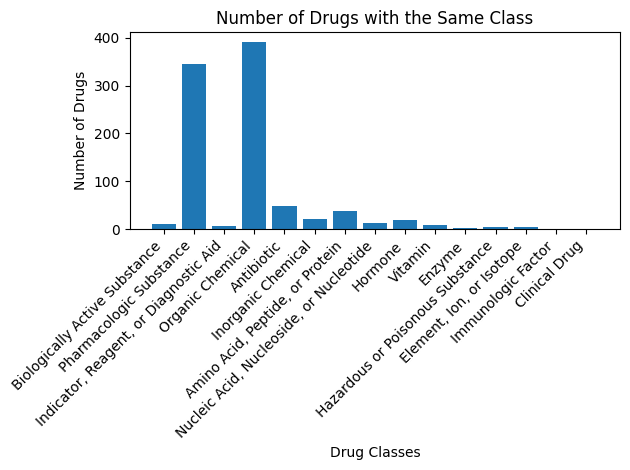

In [29]:
# Extract node classes
node_classes = nx.get_node_attributes(larg_comp, 'drug_class')

# Count the occurrences of each attribute value
attribute_counts = Counter(node_classes.values())

# Calculate percentages
total_drugs = sum(attribute_counts.values())
percentages = {label: count / total_drugs * 100 for label, count in attribute_counts.items()}

# Print counts and percentages
for label, count in attribute_counts.items():
    percentage = percentages[label]
    print(f'{label}: {count} drugs ({percentage:.2f}%)')

# Create a bar plot
labels, values = zip(*attribute_counts.items())

fig, ax = plt.subplots()
ax.bar(labels, values)

# Rotate x-axis labels for better visibility
ax.set_xticklabels(labels, rotation=45, ha='right')

ax.set_xlabel('Drug Classes')
ax.set_ylabel('Number of Drugs')
ax.set_title('Number of Drugs with the Same Class')

plt.tight_layout()
plt.show()

The initial code extracts drug classes from the graph (larg_comp) and generates a bar plot showing the distribution of drugs among various classes. Each bar on the plot represents a drug class, with the height reflecting the number of drugs in that class.

It can be seen that the classes with more drugs are 'Pharmacologic Substance' and 'Organic Chemical'. Those values can also be seen in the printed output.



Organic Chemical: 41 drugs (45.56%)
Pharmacologic Substance: 41 drugs (45.56%)
Hazardous or Poisonous Substance: 2 drugs (2.22%)
Antibiotic: 4 drugs (4.44%)
Inorganic Chemical: 1 drugs (1.11%)
Indicator, Reagent, or Diagnostic Aid: 1 drugs (1.11%)


<ipython-input-30-3da2b73327d3>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45, ha='right')


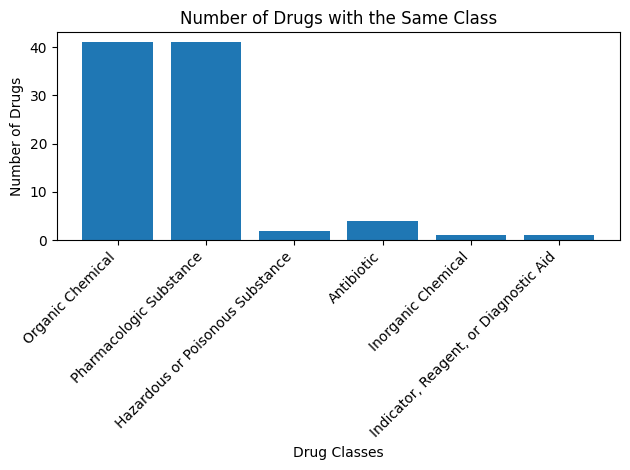

In [30]:
# Extract node classes
node_classes = nx.get_node_attributes(subgraph_high_priority, 'drug_class')

# Count the occurrences of each attribute value
attribute_counts = Counter(node_classes.values())

# Calculate percentages
total_drugs = sum(attribute_counts.values())
percentages = {label: count / total_drugs * 100 for label, count in attribute_counts.items()}

# Print counts and percentages
for label, count in attribute_counts.items():
    percentage = percentages[label]
    print(f'{label}: {count} drugs ({percentage:.2f}%)')

# Create a bar plot
labels, values = zip(*attribute_counts.items())

fig, ax = plt.subplots()
ax.bar(labels, values)

# Rotate x-axis labels for better visibility
ax.set_xticklabels(labels, rotation=45, ha='right')

ax.set_xlabel('Drug Classes')
ax.set_ylabel('Number of Drugs')
ax.set_title('Number of Drugs with the Same Class')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

The following code section performs an analysis looking into the high-priority subgraph (subgraph_high_priority). The bar plot displays the distribution of drug classes within the subset of nodes marked as high priority. We are also printing the obtained values.

According to the previous graph, we are not surprised the the highest values are achieved in the same drug classes.

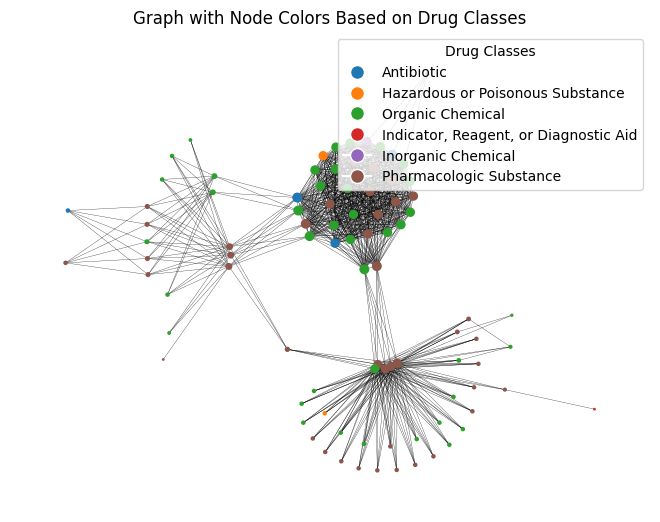

In [31]:
# Create a color map based on the unique classes
class_colors = {cls: f'C{i}' for i, cls in enumerate(set(node_classes.values()))}

node_classes = nx.get_node_attributes(subgraph_high_priority, 'drug_class')


# Assign colors to nodes based on their classes
node_colors = [class_colors[node_classes[node]] for node in subgraph_high_priority.nodes]

degrees = [subgraph_high_priority.degree[node] for node in subgraph_high_priority.nodes()]

# Draw the graph
pos = nx.kamada_kawai_layout(subgraph_high_priority,scale=0.1)
nx.draw(subgraph_high_priority,
        pos,
        node_color=node_colors,
        width = 0.2,
        with_labels=False,
        node_size = degrees,
        font_weight='bold'
        )

# Create a legend for the colors
legend_labels = {v: k for k, v in class_colors.items()}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[color],
                            markerfacecolor=color, markersize=10) for color in class_colors.values()]
plt.legend(handles=legend_handles, title='Drug Classes', loc='upper right')

plt.title('Graph with Node Colors Based on Drug Classes')
plt.show()

The third code part goes a step further by showing the high-priority subgraph as a graph, with nodes colored according to their drug classes. Each drug class gets its own color, that can be visualized in the legend. The size of each node reflects its importance in the subgraph.

These plots all together contribute to a comprehensive exploration of drug classes within the network, helping in the identification of patterns and potential insights into the network's functional organization.

### *Count the number of interactions based on drug classes for High Priority*
The following function computes and shows the top drug class pairs and their percentages in high-priority interactions within our graph. It sorts the drug class pairs based on their occurrence counts and presents the top k pairs along with their counts and percentages.

In [32]:
def compute_drug_class_pair_percentages(graph, k=5):
    # Create a dictionary to store counts of drug class pairs
    drug_class_pairs_count = {}

    # Iterate over edges in the graph
    for edge in graph.edges():
        # Extract drug classes for the nodes in the edge
        drug_class_1 = graph.nodes[edge[0]]['drug_class']
        drug_class_2 = graph.nodes[edge[1]]['drug_class']

        # Ensure the order of drug classes doesn't matter
        drug_class_pair = tuple(sorted([drug_class_1, drug_class_2]))

        # Increment the count for the drug class pair
        drug_class_pairs_count[drug_class_pair] = drug_class_pairs_count.get(drug_class_pair, 0) + 1

    # Calculate the total number of interactions
    total_interactions = sum(drug_class_pairs_count.values())

    # Sort the drug class pairs based on their counts
    sorted_drug_class_pairs = sorted(drug_class_pairs_count.items(), key=lambda x: x[1], reverse=True)


    p = 0

    # Display the sorted counts and percentages
    for drug_class_pair, count in sorted_drug_class_pairs:
        if p>k:
          break
        p+=1
        percentage = (count / total_interactions) * 100
        print(f"Drug Class Pair: {drug_class_pair}, Count: {count}, Percentage: {percentage:.2f}%")


In [33]:
print('High priority interactions: ')
compute_drug_class_pair_percentages(subgraph_high_priority)

High priority interactions: 
Drug Class Pair: ('Organic Chemical', 'Pharmacologic Substance'), Count: 302, Percentage: 37.66%
Drug Class Pair: ('Organic Chemical', 'Organic Chemical'), Count: 178, Percentage: 22.19%
Drug Class Pair: ('Pharmacologic Substance', 'Pharmacologic Substance'), Count: 149, Percentage: 18.58%
Drug Class Pair: ('Antibiotic', 'Organic Chemical'), Count: 58, Percentage: 7.23%
Drug Class Pair: ('Antibiotic', 'Pharmacologic Substance'), Count: 40, Percentage: 4.99%
Drug Class Pair: ('Hazardous or Poisonous Substance', 'Organic Chemical'), Count: 19, Percentage: 2.37%


The output shows which pairs of drug classes are most common in important interactions. For example, it tells us that interactions between 'Organic Chemical' and 'Pharmacologic Substance' are quite frequent, making up 37.66% of the important interactions. It also mentions other interesting patterns, giving us a clear idea of the different drug class pairs that matter in these high-priority connections.

In [34]:
print('All interactions: ')
compute_drug_class_pair_percentages(larg_comp)

All interactions: 
Drug Class Pair: ('Organic Chemical', 'Pharmacologic Substance'), Count: 50474, Percentage: 36.25%
Drug Class Pair: ('Organic Chemical', 'Organic Chemical'), Count: 28779, Percentage: 20.67%
Drug Class Pair: ('Pharmacologic Substance', 'Pharmacologic Substance'), Count: 22132, Percentage: 15.90%
Drug Class Pair: ('Antibiotic', 'Organic Chemical'), Count: 5955, Percentage: 4.28%
Drug Class Pair: ('Antibiotic', 'Pharmacologic Substance'), Count: 5199, Percentage: 3.73%
Drug Class Pair: ('Amino Acid, Peptide, or Protein', 'Organic Chemical'), Count: 2733, Percentage: 1.96%


The new results tell us which pairs of drug classes are most common in all the network interactions. For example, the combination of 'Organic Chemical' and 'Pharmacologic Substance' happens a lot, making up 36.25% of all interactions. We also see interactions within the same class, like 'Organic Chemical' with itself (20.67%) and 'Pharmacologic Substance' with itself (15.90%), are quite frequent. There are also mix-and-match interactions between different classes, such as 'Antibiotic' with 'Organic Chemical' (4.28%) and 'Antibiotic' with 'Pharmacologic Substance' (3.73%). These percentages give us a simple way to understand how important these specific pairs are in the big picture of the network.

# Part 2: Communities

Communities in graphs refer to groups of nodes that are densely connected internally but have fewer connections with nodes outside the group. In conclusion, they represent clusters or subgroups of nodes that show strong interconnectedness, generating distinct and cohesive units inside the larger network.

In [35]:
!pip uninstall -y community

!pip install python-louvain

Found existing installation: community 1.0.0b1
Uninstalling community-1.0.0b1:
  Successfully uninstalled community-1.0.0b1


### *Communities detection*
This code applies the Louvain algorithm to find communities in the graph larg_comp. It assigns each node to a community and adds this information to the graph nodes. The code then prints the number of identified communities and calculates modularity, which measures the quality of the community structure. Higher modularity values indicate a better-defined separation of nodes into distinct communities.

In [36]:
from community import community_louvain

# Detect communities
partition = community_louvain.best_partition(larg_comp, random_state = SEED)

# Add community information to the nodes
for node, community_id in partition.items():
    larg_comp.nodes[node]['community'] = community_id
    if subgraph_high_priority.has_node(node):
        subgraph_high_priority.nodes[node]['community'] = community_id

print("Number of communities: {}".format(len(set(partition.values()))))

modularity = community_louvain.modularity(partition, larg_comp)
print("Modularity: {}".format(round(modularity,2)))

Number of communities: 3
Modularity: 0.17


The code identified three communities within the graph, and the modularity value is 0.17. This indicates that the nodes are somehow separated into communities.

### *Nodes Distribution of Communities by Drug Class*

Then we continue by generating a stacked bar chart. It shows the distribution of drug classes across communities in a network. The x-axis shows community IDs, the y-axis displays node counts, and distinct colors represent different drug classes.

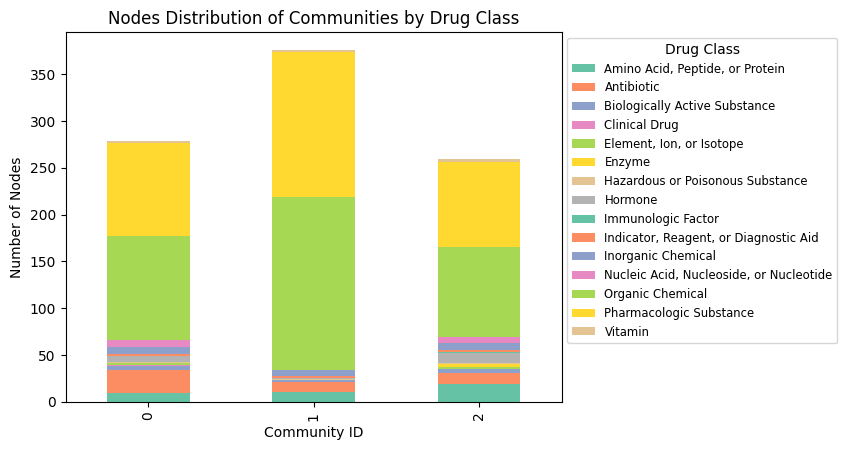

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example data (replace this with your actual data)
community_sizes = [len([node for node, data in larg_comp.nodes(data=True) if data['community'] == community_id]) for community_id in set(partition.values())]
drug_classes = [data.get('drug_class', 'Unknown') for node, data in larg_comp.nodes(data=True)]

# Create a DataFrame with community and drug class information
df = pd.DataFrame({'Community': [partition[node] for node in larg_comp.nodes],
                   'DrugClass': drug_classes})

# Create a cross-tabulation of the data
cross_tab = pd.crosstab(df['Community'], df['DrugClass'])

# Plot a stacked bar chart
ax = cross_tab.plot.bar(stacked=True, color=sns.color_palette('Set2'))

# Add labels and legend
ax.set_xlabel('Community ID')
ax.set_ylabel('Number of Nodes')
ax.legend(title='Drug Class', bbox_to_anchor=(1, 1),fontsize='small')

plt.title('Nodes Distribution of Communities by Drug Class')
plt.show()


The output shows that community 1 has the higher number of nodes. Although the other communities are smaller, do not differ a lot in the achieved number of nodes.

It is also displayed the different drug classes involved in each community.

### *High-priority interactions within each community*
This code counts how many important connections (high-priority edges) are inside each community and how many connect different communities. It helps us see where the key interactions are happening within groups and between them.





In [38]:
# Count the number of high-priority interactions inside each community
inside_community_count = {community_id: 0 for community_id in set(partition.values())}

# Count the number of high-priority interactions crossing communities
cross_community_count = 0

for source, target, data in larg_comp.edges(data=True):
    community_source = larg_comp.nodes[source]['community']
    community_target = larg_comp.nodes[target]['community']

    # Check if the edge is a high-priority edge
    if 'priority' in data and data['priority'] == 'High Priority':
        if community_source == community_target:
            # Increment the count for high-priority edges inside the community
            inside_community_count[community_source] += 1
        else:
            # Increment the count for high-priority edges crossing communities
            cross_community_count += 1

# Print the number of high-priority edges inside each community
print("\nNumber of high-priority edges inside each community:")
for community_id, count in inside_community_count.items():
    print(f"Community {community_id}: {count} high-priority edges")

# Print the number of high-priority edges crossing communities
print(f"\nNumber of high-priority edges crossing communities: {cross_community_count}")


Number of high-priority edges inside each community:
Community 0: 38 high-priority edges
Community 1: 363 high-priority edges
Community 2: 17 high-priority edges

Number of high-priority edges crossing communities: 384


The output indicates the count of high-priority edges within each community. Additionally, there are 384 high-priority edges that cross between communities. This information helps understand how high-priority interactions are distributed within and between different community structures in the graph.

### *Graph with Node Colors Based on Drug Communities*

We will create now a graph with node colors bases on drug communities. The graph is drawn using the Kamada-Kawai layout, and node sizes reflect degrees. A legend is added to denote drug communities

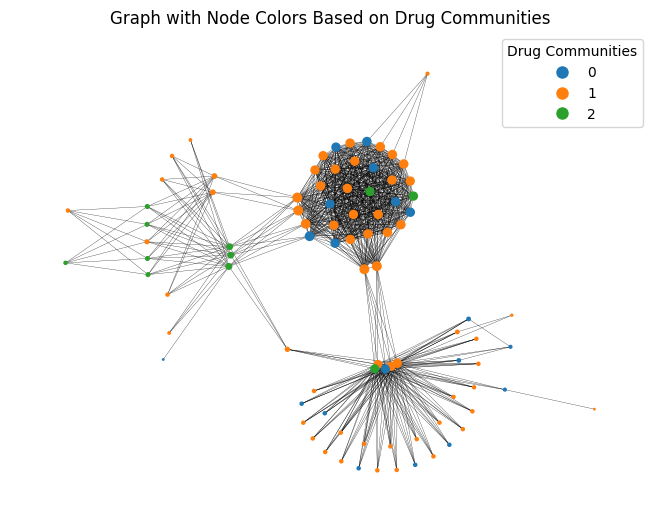

In [39]:
node_classes = nx.get_node_attributes(subgraph_high_priority, 'community')

class_colors = {cls: f'C{i}' for i, cls in enumerate(set(node_classes.values()))}

# Assign colors to nodes based on their classes
node_colors = [class_colors[node_classes[node]] for node in subgraph_high_priority.nodes]

degrees = [subgraph_high_priority.degree[node] for node in subgraph_high_priority.nodes()]

# Draw the graph
pos = nx.kamada_kawai_layout(subgraph_high_priority,scale=0.1)
nx.draw(subgraph_high_priority,
        pos,
        node_color=node_colors,
        width = 0.2,
        with_labels=False,
        node_size = degrees,
        font_weight='bold'
        )

# Create a legend for the colors
legend_labels = {v: k for k, v in class_colors.items()}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[color],
                            markerfacecolor=color, markersize=10) for color in class_colors.values()]
plt.legend(handles=legend_handles, title='Drug Communities', loc='upper right')

plt.title('Graph with Node Colors Based on Drug Communities')
plt.show()

# Part 3: Word Clouds

In a graph context, word clouds are visual representations where words are displayed in different sizes based on their frequency or importance within the graph. Nodes or attributes with higher frequency or significance appear larger, creating an easily interpretable visual summary of the graph's key elements. This technique is commonly used to highlight important nodes within a network.

### *Text preprocessing*

We start this section by getting text ready for analysis. The following tasks are being made: making all the text lowercase, removing unnecessary punctuation, breaking it into individual words, getting rid of common words like "and" or "the," and simplifying words to their base form.

This makes the text easier to work with for the tasks we will be performing (like creating word clouds).

In [40]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Step 1: Text Preprocessing
def preprocess_text(text):
    # Check for NaN values
    if pd.isnull(text):
        return []

    # Convert to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


This code creates a table, `drug_data`, to store information about drugs from the graph. It includes details like DrugID, DrugName, DrugClass, DrugCommunity, and processed DrugContent.

In [41]:
drug_data = pd.DataFrame({
    'DrugID': list(larg_comp.nodes),
    'DrugName': [larg_comp.nodes[node].get('name', 'Unknown Drug') for node in larg_comp.nodes],
    'DrugClass': [larg_comp.nodes[node].get('drug_class', 'NA') for node in larg_comp.nodes],
    'DrugCommunity': [larg_comp.nodes[node].get('community', 'NA') for node in larg_comp.nodes],
    'DrugContent': [preprocess_text(larg_comp.nodes[node].get('content', 'NA')) for node in larg_comp.nodes]
})

We create a new table, `drug_data_priority`, to handle information about drugs involved in high-priority interactions.

In [42]:
drug_data_priority = pd.DataFrame({
    'DrugID': list(subgraph_high_priority.nodes),
    'DrugName': [subgraph_high_priority.nodes[node].get('name', 'Unknown Drug') for node in subgraph_high_priority.nodes],
    'DrugClass': [subgraph_high_priority.nodes[node].get('drug_class', 'NA') for node in subgraph_high_priority.nodes],
    'DrugCommunity': [larg_comp.nodes[node].get('community', 'NA') for node in subgraph_high_priority.nodes],
    'DrugContent': [preprocess_text(subgraph_high_priority.nodes[node].get('content', 'NA')) for node in subgraph_high_priority.nodes]
})

### *TF-IDF computation & Word Cloud generation*
Two main thing are being made in this code. First, it calculates TF-IDF (Term Frequency-Inverse Document Frequency) values for the drug content in the `drug_data` table. Then, it generates a word cloud using these TF-IDF values.

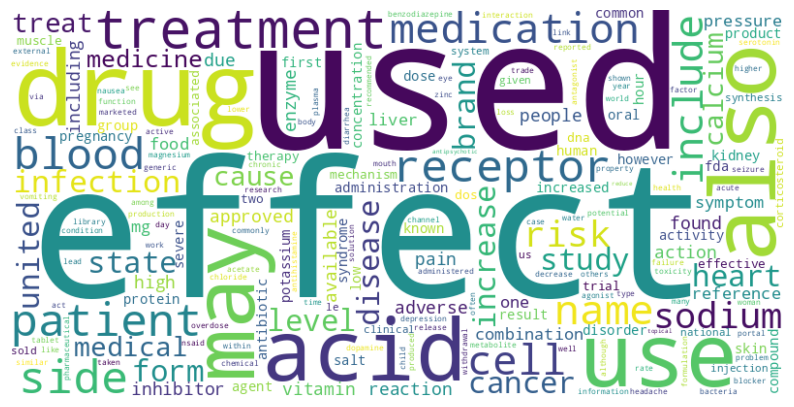

In [43]:
# Step 2: Compute TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
tfidf_matrix = tfidf_vectorizer.fit_transform(drug_data['DrugContent'].apply(lambda x: ' '.join(x)))

# Convert TF-IDF matrix to dictionary
tfidf_dict = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix.sum(axis=0).A1))

# Step 3: Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_dict)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


The resulting word cloud visually represents the importance of words in the drug content, where more significant words appear larger. The most significant words are "effect" and "used" followed by "drug", "may", "also", etc.

### *Word cloud given community*

We will now generate word clouds for each drug class in the high-priority drug data. It uses TF-IDF values once again to highlight important words specific to each class.

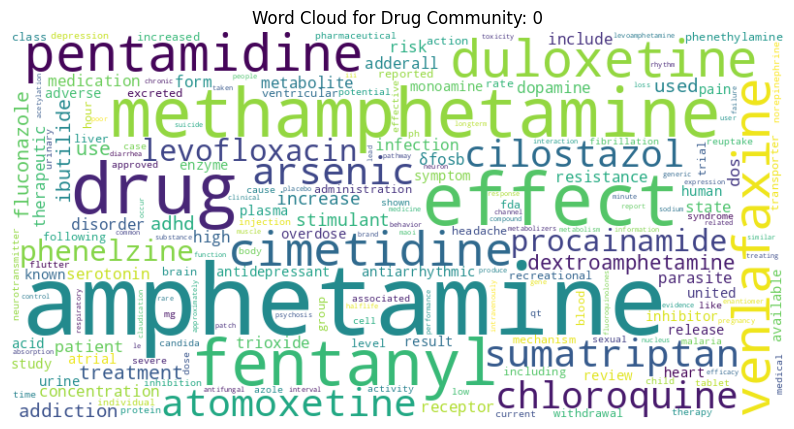

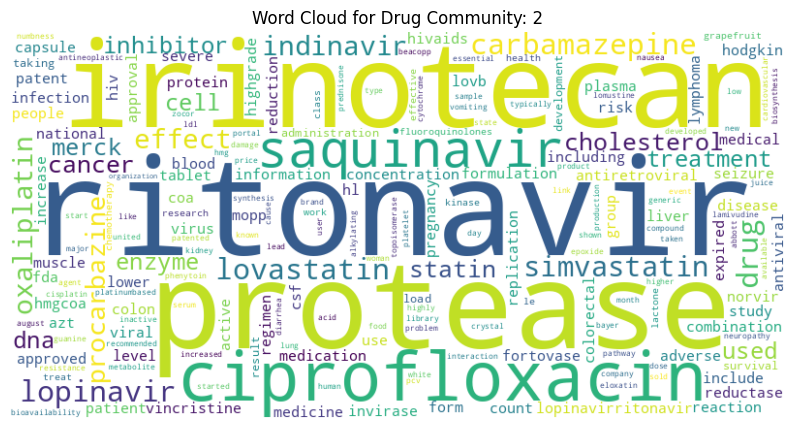

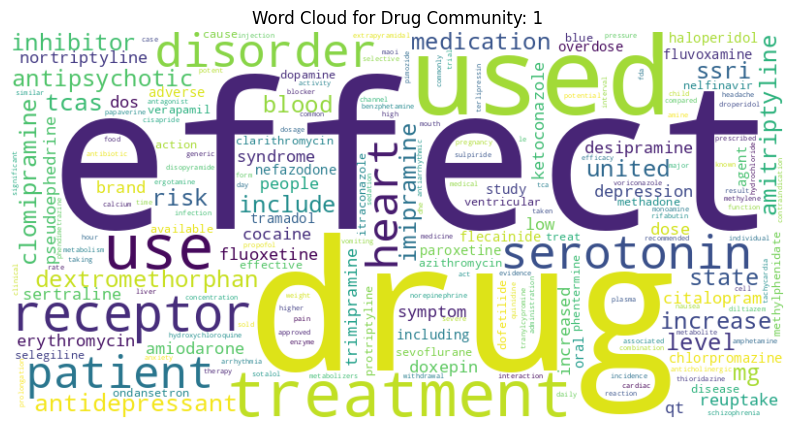

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit(drug_data_priority['DrugContent'].apply(lambda x: ' '.join(x)))

# Step 3: Generate Word Clouds for Each Drug Class
unique_classes = drug_data_priority['DrugCommunity'].unique()

for drug_class in unique_classes:
    # Filter DataFrame for the current drug class
    class_df = drug_data_priority[drug_data_priority['DrugCommunity'] == drug_class]

    # Create a separate TF-IDF matrix for the current drug class
    class_tfidf_matrix = tfidf_vectorizer.transform(class_df['DrugContent'].apply(lambda x: ' '.join(x)))

    # Convert TF-IDF matrix to dictionary
    class_tfidf_dict = dict(zip(tfidf_vectorizer.get_feature_names_out(), class_tfidf_matrix.sum(axis=0).A1))

    # Generate Word Cloud for the current drug class
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(class_tfidf_dict)

    # Plot the Word Cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Drug Community: {drug_class}')
    plt.axis('off')
    plt.show()

The obtained results are a visual representation of key terms for each drug class. This helps us to undestand quickly the different features inside each different categories.

### *Semantic similarity between drugs*

The code now finds how similar drug descriptions are by using TF-IDF values and cosine similarity. It transforms drug content into a numerical representation and then calculates the similarity scores between drugs. The resulting `cosine_sim` matrix helps us to identify how closely related drug descriptions are to each other.

In [45]:
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(drug_data['DrugContent'].apply(lambda x: ' '.join(x)))
# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [46]:
# TF-IDF vectorization for the entire dataset
vectorizer = TfidfVectorizer()
tfidf_matrix_all = vectorizer.fit_transform(drug_data['DrugContent'].apply(lambda x: ' '.join(x)))

# Function to compute semantic similarity within a community
def compute_similarity(drug_data, tfidf_matrix_all):

    # Get indices of drugs within the community
    indices = drug_data.index.tolist()

    # Extract submatrix for drugs within the community
    tfidf_matrix_community = tfidf_matrix_all[indices, :]

    # Compute cosine similarity matrix
    cosine_sim = cosine_similarity(tfidf_matrix_community, tfidf_matrix_community)

    # Compute average similarity within the community
    avg_similarity = cosine_sim.mean()

    return avg_similarity

# Example: Loop through communities and compute similarity
unique_communities = drug_data['DrugCommunity'].unique()

for community in unique_communities:
    # Filter drug data for drugs within the community
    community_data = drug_data[drug_data['DrugCommunity'] == community]

    # Compute semantic similarity within the community
    avg_similarity = compute_similarity(community_data, tfidf_matrix_all)

    print(f"Community {community}: Average Semantic Similarity: {avg_similarity}")

Community 0: Average Semantic Similarity: 0.031071693955397453
Community 1: Average Semantic Similarity: 0.03180315225688925
Community 2: Average Semantic Similarity: 0.027897950521057598


These results indicate the average semantic similarity within each drug community. Basically, these values suggest that, on average, drug descriptions within each community are somewhat similar, with the highest average similarity observed in Community 1. The similarity isn't very high, just a little bit, indicating that the words used to describe drugs in the same community share some common features.

### *Label shuffling test*

Finally a permutation test to assess whether the average semantic similarity within Community 1 is significantly different from what would be expected by random chance is made. We do this by randomly shuffling the drug data many times, calculating the average similarity each time, and comparing these random averages to the actual average similarity in Community 1.

In [47]:
import random

def randomize_drugs(drugs, size=1000):
    shuffled_df = drugs.sample(frac=1, replace=False)
    return shuffled_df.head(size)


simmilarity = []
for iter in range(1000):
    random_drugs = randomize_drugs(drug_data, size=len(drug_data[drug_data['DrugCommunity'] == 1]))
    sim = compute_similarity(random_drugs, tfidf_matrix_all)
    simmilarity.append(sim)

In [48]:
community1data = drug_data[drug_data['DrugCommunity'] == 1]
community1sim = compute_similarity(community1data, tfidf_matrix_all)

# p-value
p_value = sum(np.array(simmilarity) >= community1sim)/len(simmilarity)

print("p-value:", p_value)

p-value: 0.0


The output p-value of 0.0 indicates that the observed average similarity in Community 1 is extremely unlikely to occur by random chance. This suggests that the semantic similarity within Community 1 is significantly higher than what would be expected under the null hypothesis of random shuffling.